In [65]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, KFold
from itertools import product
import matplotlib.pyplot as plt

In [66]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the figure suptitle
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [67]:
def mean_euclidean_error(vectors1, vectors2):
    """
    Compute the mean Euclidean error between two sets of 3D vectors.

    Parameters:
    - vectors1: NumPy array of shape (N, 3) representing the first set of 3D vectors
    - vectors2: NumPy array of shape (N, 3) representing the second set of 3D vectors

    Returns:
    - mean_error: Mean Euclidean error between the two sets of vectors
    """
    # Check if the input arrays have the correct shape
    if vectors1.shape != vectors2.shape or vectors1.shape[1] != 3:
        raise ValueError("Input arrays must be of shape (N, 3)")

    # Compute Euclidean distance
    euclidean_distance = np.linalg.norm(vectors1 - vectors2, axis=1)

    # Calculate the mean Euclidean error
    mean_error = np.mean(euclidean_distance)

    return mean_error

In [68]:
def plot_mean_std(x,mee,std, label, color):
    """
    Plot mean Euclidean error (MEE) along with standard deviation.

    Parameters:
    - x (array-like): Values of the hyperparameter C or epsilon.
    - mee (array-like): Mean Euclidean error values.
    - std (array-like): Standard deviation of Euclidean error values.
    - color (str): Color for the plot.

    The function plots the mean Euclidean error (MEE) along with its
    standard deviation based on the values of the hyperparameter C or epsilon.
    """

    plt.figure(figsize=(10, 9))
    plt.plot(x,mee, label='MEE $\pm$ std. (results of k-fold cross validation)', color = color, linewidth=1)
    plt.fill_between(x,mee-std, mee+std, color=color, alpha=0.3)

    plt.xlabel(f'{label} values')
    plt.ylabel('MEE')
    plt.legend()

    plt.show()


# Load the dataset

In [69]:
from sklearn.model_selection import train_test_split

# load the dataset, split into input (X) and output (y) variables
dataset = np.loadtxt('ML-CUP23-TR.csv', delimiter=',')
X = dataset[:,1:11]
y = dataset[:,11:14]

# Split the data into training and testing sets (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
from sklearn.metrics import make_scorer
mean_euclidean_scorer = make_scorer(mean_euclidean_error, greater_is_better=False)




def perform_grid_search_kfold(ks,weightss,ps, k_folds, X, y):
    mees_mean = []
    mees_sd = []
    # Best k and its corresponding score
    best_k = None
    best_score = float('inf')

    # K-Fold cross-validation
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Trying different k values
    for k, weights, p in product(ks, weightss,ps):
        model = KNeighborsRegressor(n_neighbors=k, weights=weights, p=p)
        # Negative Mean Squared Error as scoring
        scores = cross_val_score(model, X, y, cv=kf, scoring=mean_euclidean_scorer)
        mean_score = -scores.mean()  # Convert back to positive MSE
        mees_mean.append(mean_score)
        mees_sd.append(-scores.std())
        print(f"k={k}, w={weights}, p={p}, Mean Squared Error: {mean_score}")

        if mean_score < best_score:
            best_k = k
            best_weight = weights
            best_p = p
            best_score = mean_score

    print(f"The best k is {best_k} {best_weight} {best_p}  with a MEE of {best_score}")

    #  train the final model with the best k
    final_model = KNeighborsRegressor(n_neighbors=best_k, weights=best_weight,p = best_p)
    final_model.fit(X_train, y_train)

    return final_model

# Perform A grid search

In [71]:
# Define a range of potential k values
ks = range(1, 31)
weightss=['uniform','distance']
ps = range(1,10)
perform_grid_search_kfold(ks,weightss,ps,k_folds=3,X=X_train,y=y_train)

k=1, w=uniform, p=1, Mean Squared Error: 4.033859243211219
k=1, w=uniform, p=2, Mean Squared Error: 4.022883363593918
k=1, w=uniform, p=3, Mean Squared Error: 4.074407189059509
k=1, w=uniform, p=4, Mean Squared Error: 4.121000476417733
k=1, w=uniform, p=5, Mean Squared Error: 4.134704060326629
k=1, w=uniform, p=6, Mean Squared Error: 4.142880418187434
k=1, w=uniform, p=7, Mean Squared Error: 4.1408413166920885
k=1, w=uniform, p=8, Mean Squared Error: 4.154501206754666
k=1, w=uniform, p=9, Mean Squared Error: 4.1834609240748515
k=1, w=distance, p=1, Mean Squared Error: 4.033859243211219
k=1, w=distance, p=2, Mean Squared Error: 4.022883363593917
k=1, w=distance, p=3, Mean Squared Error: 4.074407189059509
k=1, w=distance, p=4, Mean Squared Error: 4.121000476417733
k=1, w=distance, p=5, Mean Squared Error: 4.134704060326629
k=1, w=distance, p=6, Mean Squared Error: 4.142880418187434
k=1, w=distance, p=7, Mean Squared Error: 4.1408413166920885
k=1, w=distance, p=8, Mean Squared Error: 4.15

KNeighborsRegressor(p=1, weights='distance')

# Plot the effect of K

k=1 Mean Squared Error: 4.033859243211219
k=2 Mean Squared Error: 3.2633520690728837
k=3 Mean Squared Error: 3.0732294722357785
k=4 Mean Squared Error: 3.0415324690853844
k=5 Mean Squared Error: 3.026990373401532
k=6 Mean Squared Error: 3.045275780477239
k=7 Mean Squared Error: 3.0741230003961575
k=8 Mean Squared Error: 3.154964326899833
k=9 Mean Squared Error: 3.201212635217349
k=10 Mean Squared Error: 3.2509889477433873
k=11 Mean Squared Error: 3.318662711476449
k=12 Mean Squared Error: 3.3690087584807316
k=13 Mean Squared Error: 3.447259968216883
k=14 Mean Squared Error: 3.5077337054877815
k=15 Mean Squared Error: 3.570101670162874
k=16 Mean Squared Error: 3.6321062838238602
k=17 Mean Squared Error: 3.6859470196590434
k=18 Mean Squared Error: 3.7590555748878987
k=19 Mean Squared Error: 3.8281348667516775
k=20 Mean Squared Error: 3.893175435015675
k=21 Mean Squared Error: 3.949610707619385
k=22 Mean Squared Error: 4.014270470561584
k=23 Mean Squared Error: 4.072972928975674
k=24 Mean

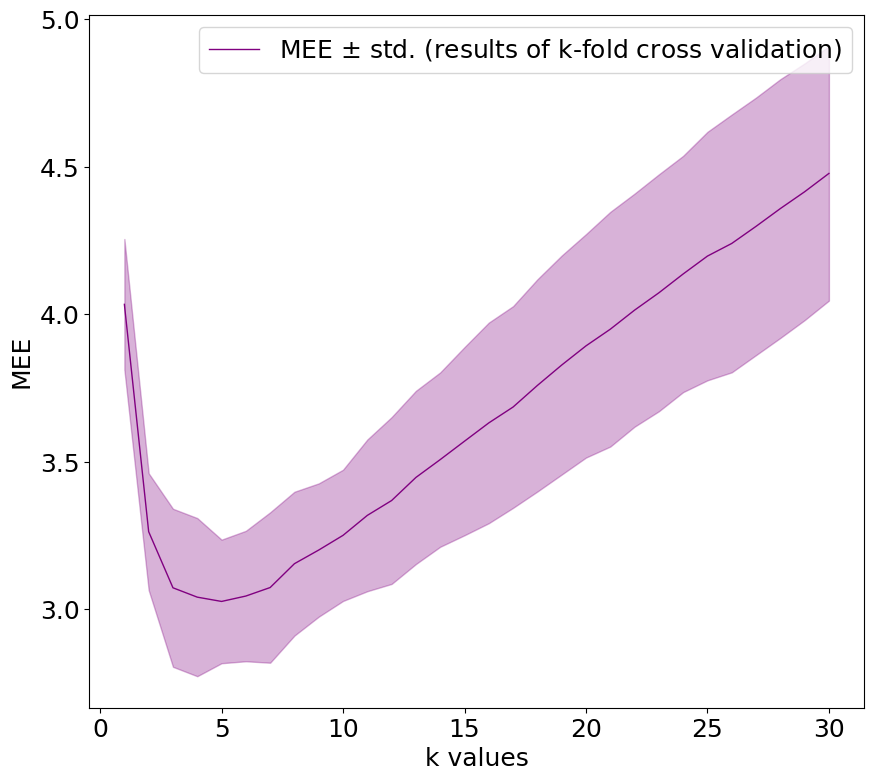

In [72]:
mees_mean = []
mees_sd = []
# Best k and its corresponding score
best_k = None
best_score = float('inf')

k_values = range(1, 31)

# K-Fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Trying different k values
for k in k_values:
    model = KNeighborsRegressor(n_neighbors=k, weights='distance',p = 1)
    # Negative Mean Squared Error as scoring
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=mean_euclidean_scorer)
    mean_score = -scores.mean()  # Convert back to positive MSE
    mees_mean.append(mean_score)
    mees_sd.append(scores.std())
    print(f"k={k} Mean Squared Error: {mean_score}")

    if mean_score < best_score:
        best_k = k
        best_score = mean_score
        best_score_sd = scores.std()

print(f"The best k is {best_k}  with a MEE of {best_score:.4} +- {best_score_sd:.4}")

#  train the final model with the best k
final_model = KNeighborsRegressor(n_neighbors=best_k, weights='distance',p = 1)
final_model.fit(X_train, y_train)

plot_mean_std(k_values,np.array(mees_mean),np.array(mees_sd),label='k', color='purple')
